In [1]:
import json
import copy

import numpy
import matplotlib
from matplotlib import pyplot
import pyhf

import blind
import jsongz

In [2]:
import jax
import scipy.optimize

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)
pyhf.set_backend("jax")

In [3]:
SPEC = jsongz.load("ins1852821_bkg.json.gz")
# SPEC = jsongz.load("ins1852821_signal.json.gz")

In [4]:
[channel["name"] for channel in SPEC["channels"]]

['SR0bvetoloose_cuts',
 'SR0bvetotight_cuts',
 'SR0breq_cuts',
 'SR1bvetoloose_cuts',
 'SR1bvetotight_cuts',
 'SR1breq_cuts',
 'SR2bvetoloose_cuts',
 'SR2bvetotight_cuts',
 'SR2breq_cuts',
 'SR0ZZloose_cuts',
 'SR0ZZtight_cuts',
 'SR0ZZbvetoloose_cuts',
 'SR0ZZbvetotight_cuts',
 'SR5L_cuts',
 'CRZZ_cuts',
 'CRttZ_cuts']

In [5]:
# SR_NAME = "SR0bvetotight_cuts"
SR_NAME = "SR0ZZloose_cuts"
# SR_NAME = "SR0ZZtight_cuts"
# SR_NAME = "SR0ZZbvetotight_cuts"
# atlas_susy_4l presents yields without SR constraints
# (sensibly, but violating ATLAS SUSY policy)

In [6]:
def get_named(seq, name):
    for item in seq:
        if item["name"] == name:
            return item
    raise KeyError(name)

In [7]:
def add_signal(
    spec,
    channel_name,
    measurement_name="NormalMeasurement",
    poi_name="mu_SIG",
):
    # add a dummy signal to its channel
    channel = get_named(spec["channels"], channel_name)

    channel["samples"].append({
        "data": [0.0],
        "modifiers": [{
            "data": None,
            "name": poi_name,
            "type": "normfactor", 
        }],
        "name": "signal",
    })
    
    # add a its modifier name to the measurement
    measurement = get_named(spec["measurements"], measurement_name)
    measurement["config"]["parameters"].append({
        "bounds": [[0.0, 2.0]],
        "fixed": False,
        "inits": [1.0],
        "name": poi_name,
    })
    measurement["config"]["poi"] = poi_name
    
    return spec

In [8]:
def make_model_and_data(spec, signal_channel_name):
    spec = copy.deepcopy(spec)
    spec = add_signal(spec, signal_channel_name)
    workspace = pyhf.workspace.Workspace(spec)
    
    channels_keep = {
        signal_channel_name,
        # TODO arguments?
        "CRZZ_cuts",
        "CRttZ_cuts",
    }
        
    channels_prune = workspace.channel_slices.keys() - channels_keep
    
    workspace_pruned = workspace.prune(channels=channels_prune)
    
    model = workspace_pruned.model()
    data = numpy.array(workspace_pruned.data(model))
    
    return model, data


MODEL, DATA = make_model_and_data(SPEC, SR_NAME)

In [9]:
def test_logpdf(model, data, signal_channel_name):
    parameters = numpy.array(model.config.suggested_init())
    
    print(model.logpdf(parameters, data))
    
    print(blind.model_logpdf_blind(model, parameters, data, []))
    
    logf = blind.model_logpdf_blind(model, parameters, data, {signal_channel_name})
    print(logf)

    slice_ = model.config.channel_slices[signal_channel_name]
    expected_data = model.expected_actualdata(parameters)
    mu = expected_data[slice_]
    nobs = data[slice_]
    print(mu, nobs)

    loglikelihood = pyhf.probability.Poisson(mu).log_prob(numpy.array(nobs))
    print(loglikelihood)
    print(logf + loglikelihood)


test_logpdf(MODEL, DATA, SR_NAME)

[-105.97103393]
[-105.97103393]
[-101.97906232]
[144.28615681] [157.]
[-3.99197161]
[-105.97103393]


In [10]:
def test_hess():
    def f(x):
        return 0.5 * x ** 2
    
    print(jax.hessian(f)(0.1))
    
test_hess()

1.0


In [11]:
def inner_product(x, c):
    return x.dot(c.dot(x))

In [12]:
def d2fdx2(fminus, f, fplus, eps):
    return ((fplus - f) - (f - fminus)) / eps ** 2

In [13]:
def test_opt(model, data, signal_channel_name):
    blind_bins = {signal_channel_name}
    
    def f(x):
        logy, = blind.model_logpdf_blind(model, x, data, blind_bins)
        return -logy
    
    fjit = jax.jit(jax.value_and_grad(f))
          
    parameters = numpy.array(model.config.suggested_init())
    bounds = numpy.array(model.config.suggested_bounds())
    
    print(fjit(parameters)[0])

    result = scipy.optimize.minimize(
        fjit,
        parameters,
        bounds=bounds,
        jac=True,
        method="L-BFGS-B",
        options=dict(ftol=1e-10, gtol=1e-10),
    )
    
    print(result)
    
    # SR yields
    slice_ = model.config.channel_slices[signal_channel_name]
    
    def y(x):
        expected_data = model.expected_actualdata(x)
        yres, = expected_data[slice_]
        return yres
    
    print(y(parameters))
    print(y(result.x))
    
    ygrad = jax.grad(y)(result.x)
    
    def cov_jax(x):
        hess = jax.hessian(f)(x)
        return jax.numpy.linalg.inv(hess)
    
    cov_lbfgs = result.hess_inv.todense()
    cov = numpy.array(cov_jax(result.x))
    
    var_lbfgs = inner_product(ygrad, result.hess_inv)
    var = inner_product(ygrad, cov)
    
    print("std")
    print(var_lbfgs ** 0.5)
    # jax hessian seems to give broken answers - numerical failure?
    print(var ** 0.5)


test_opt(MODEL, DATA, SR_NAME)

101.97906231564971
      fun: 80.16637821412505
 hess_inv: <99x99 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.18211177e-03,  0.00000000e+00,  3.25739360e-05,  2.17581909e-06,
        1.96030585e-07,  1.12267320e-08,  3.74742198e-06,  9.89424611e-09,
        1.71844661e-06,  4.02142200e-06,  1.46761960e-06, -5.57477385e-06,
       -6.77430202e-06, -7.59327392e-07,  2.82090360e-06, -5.59660115e-07,
       -3.56380934e-05,  2.79685709e-05,  1.32704743e-05,  6.76208823e-06,
       -6.83709578e-06,  3.71437171e-06,  0.00000000e+00,  9.84842957e-06,
        2.31812546e-05,  1.69905205e-05,  3.57932937e-06, -9.04959479e-07,
        1.54219762e-04,  0.00000000e+00,  1.68462182e-05, -2.88172592e-06,
       -1.63445349e-06,  1.30913898e-06, -9.91408839e-06, -7.76254140e-06,
       -3.46850157e-06,  1.13821936e-05, -3.99462286e-06, -6.00088900e-06,
       -6.34154114e-06,  1.74069856e-05, -1.43007308e-10,  6.69260554e-09,
       -8.00931541e-07, -1.85764439e-05,  5.79487369e-06, 

# optimize with constraints

In [14]:
def piecewise_linear_roots(f, x):
    """Return a list of points for which f(x) = 0 in a linear interpolation."""
    results = []
    for f1, f2, x1, x2 in zip(f[:-1], f[1:], x[:-1], x[1:]):
        # root implies that f1 f2 change sign
        if not f1 * f2 <= 0:
            continue
        # zero step special case
        if x1 == x2:
            if f1 == 0:
                results.append(x1)
            continue
        # zero change special case
        if f1 == f2:
            if f1 == 0:
                # panic! entire line segment is a root
                results.append(numpy.nan)
            continue
        # approx f = f1 + (x - x1) * (f2 - f1) / (x2 - x1)
        #          = f1 + (x - x1) * dfdx
        # f = 0 =>
        #        x = x1 + (0 - f1) / dfdfx
        xroot = x1 - f1 * (x2 - x1) / (f2 - f1)
        results.append(xroot)
    return results

f =  80.16637890947715
y =  161.24062469925585
f =  102.19932199272469
y =  3.99999972224356
50.0 92.80459744629732
60.0 88.87970231421176
70.0 86.17270701342402
80.0 84.26201226879785
90.0 82.908719669177
100.0 81.95249531297678
110.0 81.28094041727314
120.0 80.81831043519715
130.0 80.50872496681927
140.0 80.31273446735968
150.0 80.20453535068067
160.0 80.1668059432604
170.0 80.18682724494266
180.0 80.25446736008554
190.0 80.3613431020234
200.0 80.50046013324055
210.0 80.6659926584869
220.0 80.8530999207168
230.0 81.0577706090959
240.0 81.27670652500764
250.0 81.50725023129074
260.0 81.74733887932985
270.0 81.99546576906984
280.0 82.25046488188833
290.0 82.5112103100049
300.0 82.77672660806913
310.0 83.04616885488862
320.0 83.3188189794096
330.0 83.59407946785844
340.0 83.8713699941231
350.0 84.15038666100037
360.0 84.43061748242484
370.0 84.71184546059284
380.0 84.99372591785303
390.0 85.27602200312926
400.0 85.55841806078512


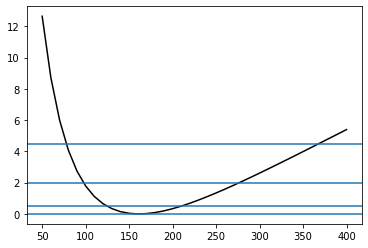

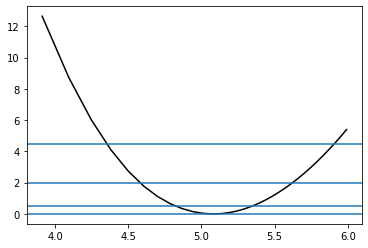

[124.90757936785833, 210.02064329228287]


In [15]:
def test_opt_constrain(model, data, signal_channel_name):
    blind_bins = {signal_channel_name}
    
    # optimization
    def f(x):
        logy, = blind.model_logpdf_blind(model, x, data, blind_bins)
        return -logy
    
    fjit = jax.jit(jax.value_and_grad(f))
          
    parameters = numpy.array(model.config.suggested_init())
    bounds = numpy.array(model.config.suggested_bounds())
    
    result = scipy.optimize.minimize(
        fjit,
        parameters,
        bounds=bounds,
        jac=True,
        method="L-BFGS-B",
    )
    
    # SR yields
    slice_ = model.config.channel_slices[signal_channel_name]
    
    def y(x):
        expected_data = model.expected_actualdata(x)
        yres, = expected_data[slice_]
        return yres
    
    yjit = jax.jit(y)
    
    print("f = ", result.fun)
    print("y = ", yjit(result.x))
    
    # constrain
    ygrad = jax.jit(jax.grad(y))
    
    yfix = 4.0
    fix = scipy.optimize.NonlinearConstraint(y, yfix, yfix, jac=ygrad)
        
    result2 = scipy.optimize.minimize(
        fjit,
        parameters,
        bounds=bounds,
        jac=True,
        method="SLSQP",
        constraints=fix,
    )

    print("f = ", result2.fun)
    print("y = ", yjit(result2.x))
    
    x0test = result.x
    
    # scan
    def fmax_given_yfix(yfix):
        fix = scipy.optimize.NonlinearConstraint(
            y, 
            yfix, 
            yfix, 
            jac=ygrad,
        )

        result = scipy.optimize.minimize(
            fjit,
            x0test,
            bounds=bounds,
            jac=True,
            method="SLSQP",
            constraints=fix,
        )
        
        return result.fun
    
    ypoints = numpy.linspace(50., 400., 36)
    
    fs = []
    for yfix in ypoints:
        fmax = fmax_given_yfix(yfix)
        print(yfix, fmax)
        fs.append(fmax)
        
    fs = numpy.array(fs)
    
    pyplot.plot(ypoints, fs - result.fun, "k")
    for sigma in (0, 1, 2, 3):
        fsigma = 0.5 * sigma ** 2
        pyplot.axhline(fsigma)
    pyplot.plot
    pyplot.show()   
    
    pyplot.plot(numpy.log(ypoints), fs - result.fun, "k")
    for sigma in (0, 1, 2, 3):
        fsigma = 0.5 * sigma ** 2
        pyplot.axhline(fsigma)
    pyplot.plot
    pyplot.show()
    
    print(piecewise_linear_roots(fs - result.fun - 0.5, ypoints))
        


test_opt_constrain(MODEL, DATA, SR_NAME)

In [16]:
def print_fit_stuff():
    lo, hi = 124.90757920360802, 210.02064368362807
    mid = 161.24062469925585
    
    err_lo = mid - lo
    err_hi = hi - mid
    print("%.1f +%.1f -%.1f" % (mid, err_lo, err_hi))

print_fit_stuff()

161.2 +36.3 -48.8
